## Setup YOLO and Data For Training

In [1]:
! unzip -qq YOLOX.zip
! unzip -qq character-detection-datasets.zip

%cd YOLOX

! pip install ninja
! pip install numpy
! pip install opencv_python
! pip install loguru
! pip install tqdm
! pip install thop
! pip install tabulate
! pip install psutil
! pip install tensorboard
! pip install pycocotools
! python setup.py build develop

/content/YOLOX
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.9 MB/s eta 0:00:00
  Attempting uninstall: nvidi

## Import Libraries for Training and Testing

In [2]:
import os
from dataclasses import dataclass

from yolox.exp import Exp as MyExp


import argparse
import random
import warnings
from loguru import logger

import torch
import torch.backends.cudnn as cudnn

from yolox.exp import Exp, check_exp_value, get_exp
from yolox.utils import configure_module, configure_nccl, configure_omp, get_num_devices

from yolox.data.data_augment import ValTransform
import cv2
from yolox.utils import postprocess, vis
import time

import matplotlib.pyplot as plt

## Define Model and Training Config

In [3]:
# class Exp(MyExp):
#     def __init__(self):
#         super(Exp, self).__init__()
#         self.depth = 0.33
#         self.width = 0.50
#         self.exp_name = "Character-Detection"

#         self.data_dir = "/content/character-detection-datasets"
#         self.train_ann = "train.json"
#         self.val_ann = "test.json"

#         self.num_classes = 36

#         self.max_epoch = 50
#         self.eval_interval = 1
#         self.data_num_workers = 4


# class TrainingConfig:
#     experiment_name: str = "CharacterDetection"
#     batch_size: int = 16
#     resume: bool = False
#     ckpt: str = None
#     start_epoch: int = 1
#     num_machines: int = 1
#     machine_rank: int = 0
#     fp16: bool = False
#     occupy: bool = False
#     logger: str = 'tensorboard'
#     output_dir = 'checkpoints/'
#     cache: str = None


class Exp(MyExp):
    def __init__(self):
        super(Exp, self).__init__()
        self.depth = 0.33
        self.width = 0.50
        self.exp_name = "Character-Detection"

        # Dataset
        self.data_dir = "/content/character-detection-datasets"
        self.train_ann = "train.json"
        self.val_ann = "test.json"
        self.num_classes = 36

        # Model Input and Augmentations
        self.input_size = (640, 640)
        self.test_size = (640, 640)
        self.mosaic_prob = 0.5
        self.mixup_prob = 0.2
        self.hsv_prob = 1.0
        self.flip_prob = 0.5

        # Training Settings
        self.max_epoch = 50
        self.warmup_epochs = 5
        self.eval_interval = 1
        self.data_num_workers = 4

@dataclass
class TrainingConfig:
    experiment_name: str = "CharacterDetection"
    batch_size: int = 16
    resume: bool = False
    ckpt: str = None
    start_epoch: int = 1
    num_machines: int = 1
    machine_rank: int = 0
    fp16: bool = True
    occupy: bool = False
    logger: str = 'tensorboard'
    output_dir = 'checkpoints/'
    cache: str = None


## Load Model and Train

In [4]:
args = TrainingConfig()
exp = Exp()
trainer = exp.get_trainer(args)
trainer.train()

/content/YOLOX/yolox/core/trainer.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=args.fp16)
2025-02-15 00:49:59 | INFO     | yolox.core.trainer:132 - args: TrainingConfig(experiment_name='CharacterDetection', batch_size=16, resume=False, ckpt=None, start_epoch=1, num_machines=1, machine_rank=0, fp16=True, occupy=False, logger='tensorboard', cache=None)
2025-02-15 00:49:59 | INFO     | yolox.core.trainer:133 - exp value:
╒═══════════════════╤═════════════════════════════════════════╕
│ keys              │ values                                  │
╞═══════════════════╪═════════════════════════════════════════╡
│ seed              │ None                                    │
├───────────────────┼─────────────────────────────────────────┤
│ output_dir        │ './YOLOX_outputs'                       │
├───────────────────┼──────────────────────────────────

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
2025-02-15 00:50:01 | INFO     | yolox.core.trainer:157 - init prefetcher, this might take one minute or less...


loading annotations into memory...
Done (t=0.34s)
creating index...
index created!


2025-02-15 00:50:05 | INFO     | yolox.core.trainer:196 - Training start...
2025-02-15 00:50:05 | INFO     | yolox.core.trainer:197 - 
YOLOX(
  (backbone): YOLOPAFPN(
    (backbone): CSPDarknet(
      (stem): Focus(
        (conv): BaseConv(
          (conv): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
      )
      (dark2): Sequential(
        (0): BaseConv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (1): CSPLayer(
          (conv1): BaseConv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.18 seconds.
Accumulating evaluation results...


2025-02-15 00:51:26 | INFO     | yolox.core.trainer:381 - 
Average forward time: 10.88 ms, Average NMS time: 2.29 ms, Average inference time: 13.17 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-15 00:51:26 | INFO     | yolox.core.trainer:218 - ---> start train epoch2
2025-02-15 00:51:30 | INFO     | yolox.core.trainer:270 - epoch: 2/50, iter: 10/129, gpu mem: 4994Mb, mem: 3.6Gb, iter_time: 0.397s, data_time: 0.007s, total_loss: 13.3, iou_loss: 4.3, l1_loss: 0.0, conf_loss: 7.2, cls_loss: 1.8, lr: 1.161e-04, size: 480, ETA: 0:54:58
2025-02-15 00:51:34 | INFO     | yolox.core.trainer:270 - epoch: 2/50, iter: 20/129, gpu mem: 4994Mb, mem: 3.5Gb, iter_time: 0.441s, data_time: 0.009s, total_loss: 17.1, iou_loss: 4.4, l1_loss: 0.0, conf_loss: 11.0, cls_loss: 1.7, lr: 1.334e-04, size: 704, ETA: 0:54:18
2025-02-15 00:51:40 | INFO     | yolox.core.trainer:270 - epoch: 2/50, iter: 30/129, gpu mem: 4994Mb, mem: 3.5Gb, iter_time: 0.542s, data_time: 0.006s, total_loss: 14.4, iou_loss: 4.2, l1_loss: 0.0, conf_loss: 8.2, cls_loss: 2.0, lr: 1.519e-04, size: 672, ETA: 0:54:23
2025-02-15 00:51:44 | INFO     | yolox.core.trainer:270 - epoch: 2/50, iter: 40/129, gpu mem: 4994Mb, mem: 3.5

Loading and preparing results...
DONE (t=0.42s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 00:52:41 | INFO     | yolox.core.trainer:381 - 
Average forward time: 9.10 ms, Average NMS time: 5.52 ms, Average inference time: 14.62 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

COCOeval_opt.evaluate() finished in 0.33 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.13 seconds.


2025-02-15 00:52:42 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 00:52:42 | INFO     | yolox.core.trainer:218 - ---> start train epoch3
2025-02-15 00:52:47 | INFO     | yolox.core.trainer:270 - epoch: 3/50, iter: 10/129, gpu mem: 4994Mb, mem: 3.6Gb, iter_time: 0.520s, data_time: 0.006s, total_loss: 10.8, iou_loss: 3.3, l1_loss: 0.0, conf_loss: 4.8, cls_loss: 2.8, lr: 4.316e-04, size: 512, ETA: 0:51:07
2025-02-15 00:52:52 | INFO     | yolox.core.trainer:270 - epoch: 3/50, iter: 20/129, gpu mem: 4994Mb, mem: 3.6Gb, iter_time: 0.456s, data_time: 0.010s, total_loss: 11.5, iou_loss: 3.2, l1_loss: 0.0, conf_loss: 5.6, cls_loss: 2.8, lr: 4.644e-04, size: 672, ETA: 0:50:53
2025-02-15 00:52:57 | INFO     | yolox.core.trainer:270 - epoch: 3/50, iter: 30/129, gpu mem: 4994Mb, mem: 3.6Gb, iter_time: 0.545s, data_time: 0.006s, total_loss: 11.5, iou_loss: 2.9, l1_loss: 0.0, conf_loss: 5.6, cls_loss: 2.9, lr: 4.984e-04, size: 768, ETA: 0:50:59
20

Loading and preparing results...
DONE (t=0.94s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 1.13 seconds.
Accumulating evaluation results...


2025-02-15 00:54:03 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.88 ms, Average NMS time: 2.26 ms, Average inference time: 10.14 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.006
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.026
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.114
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.129
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.119
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

COCOeval_opt.accumulate() finished in 0.46 seconds.


2025-02-15 00:54:03 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 00:54:03 | INFO     | yolox.core.trainer:218 - ---> start train epoch4
2025-02-15 00:54:08 | INFO     | yolox.core.trainer:270 - epoch: 4/50, iter: 10/129, gpu mem: 4994Mb, mem: 3.7Gb, iter_time: 0.498s, data_time: 0.010s, total_loss: 9.2, iou_loss: 2.8, l1_loss: 0.0, conf_loss: 3.9, cls_loss: 2.6, lr: 9.471e-04, size: 768, ETA: 0:49:38
2025-02-15 00:54:14 | INFO     | yolox.core.trainer:270 - epoch: 4/50, iter: 20/129, gpu mem: 4994Mb, mem: 3.6Gb, iter_time: 0.593s, data_time: 0.006s, total_loss: 8.7, iou_loss: 2.5, l1_loss: 0.0, conf_loss: 3.5, cls_loss: 2.7, lr: 9.954e-04, size: 640, ETA: 0:49:48
2025-02-15 00:54:20 | INFO     | yolox.core.trainer:270 - epoch: 4/50, iter: 30/129, gpu mem: 4996Mb, mem: 3.7Gb, iter_time: 0.536s, data_time: 0.008s, total_loss: 9.4, iou_loss: 2.8, l1_loss: 0.0, conf_loss: 4.2, cls_loss: 2.4, lr: 1.045e-03, size: 800, ETA: 0:49:49
2025-

Loading and preparing results...
DONE (t=1.14s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 3.56 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.47 seconds.


2025-02-15 00:55:34 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.39 ms, Average NMS time: 2.67 ms, Average inference time: 10.06 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.111
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.055
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.055
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.031
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.107
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.248
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.251
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.178
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

Loading and preparing results...
DONE (t=0.14s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 1.46 seconds.
Accumulating evaluation results...


2025-02-15 00:56:52 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.84 ms, Average NMS time: 3.52 ms, Average inference time: 11.36 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.017
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.041
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.120
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.120
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.099
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

COCOeval_opt.accumulate() finished in 0.59 seconds.


2025-02-15 00:56:52 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 00:56:53 | INFO     | yolox.core.trainer:218 - ---> start train epoch6
2025-02-15 00:57:03 | INFO     | yolox.core.trainer:270 - epoch: 6/50, iter: 10/129, gpu mem: 5000Mb, mem: 3.7Gb, iter_time: 1.025s, data_time: 0.007s, total_loss: 5.8, iou_loss: 2.1, l1_loss: 0.0, conf_loss: 1.9, cls_loss: 1.8, lr: 2.500e-03, size: 544, ETA: 0:48:23
2025-02-15 00:57:09 | INFO     | yolox.core.trainer:270 - epoch: 6/50, iter: 20/129, gpu mem: 5000Mb, mem: 3.7Gb, iter_time: 0.577s, data_time: 0.008s, total_loss: 5.8, iou_loss: 2.1, l1_loss: 0.0, conf_loss: 2.2, cls_loss: 1.5, lr: 2.500e-03, size: 672, ETA: 0:48:24
2025-02-15 00:57:13 | INFO     | yolox.core.trainer:270 - epoch: 6/50, iter: 30/129, gpu mem: 5000Mb, mem: 3.7Gb, iter_time: 0.414s, data_time: 0.005s, total_loss: 5.5, iou_loss: 1.9, l1_loss: 0.0, conf_loss: 1.9, cls_loss: 1.7, lr: 2.500e-03, size: 544, ETA: 0:48:12
2025-

Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.51 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.19 seconds.


2025-02-15 00:58:10 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.24 ms, Average NMS time: 1.53 ms, Average inference time: 8.77 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.454
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.737
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.525
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.332
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.467
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.482
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.503
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.566
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.566
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.417
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.19s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 2.47 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.47 seconds.


2025-02-15 00:59:40 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.27 ms, Average NMS time: 1.65 ms, Average inference time: 8.92 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.495
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.766
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.600
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.319
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.506
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.551
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.605
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.605
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.434
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:00:55 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.98 ms, Average NMS time: 2.93 ms, Average inference time: 10.91 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.506
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.846
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.574
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.465
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.512
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.536
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.541
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.602
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.602
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.518
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

COCOeval_opt.evaluate() finished in 0.31 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.11 seconds.


2025-02-15 01:00:56 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:00:56 | INFO     | yolox.core.trainer:218 - ---> start train epoch9
2025-02-15 01:01:02 | INFO     | yolox.core.trainer:270 - epoch: 9/50, iter: 10/129, gpu mem: 5010Mb, mem: 3.7Gb, iter_time: 0.572s, data_time: 0.007s, total_loss: 4.5, iou_loss: 1.8, l1_loss: 0.0, conf_loss: 1.6, cls_loss: 1.0, lr: 2.439e-03, size: 800, ETA: 0:46:00
2025-02-15 01:01:07 | INFO     | yolox.core.trainer:270 - epoch: 9/50, iter: 20/129, gpu mem: 5010Mb, mem: 3.7Gb, iter_time: 0.542s, data_time: 0.003s, total_loss: 4.8, iou_loss: 2.1, l1_loss: 0.0, conf_loss: 1.5, cls_loss: 1.3, lr: 2.436e-03, size: 512, ETA: 0:45:56
2025-02-15 01:01:12 | INFO     | yolox.core.trainer:270 - epoch: 9/50, iter: 30/129, gpu mem: 5010Mb, mem: 3.7Gb, iter_time: 0.497s, data_time: 0.011s, total_loss: 4.4, iou_loss: 1.9, l1_loss: 0.0, conf_loss: 1.4, cls_loss: 1.1, lr: 2.433e-03, size: 544, ETA: 0:45:51
2025-

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:02:14 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.38 ms, Average NMS time: 1.74 ms, Average inference time: 9.12 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.600
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.906
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.741
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.507
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.606
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.639
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.623
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.670
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.670
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.558
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.61 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-15 01:02:14 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:02:14 | INFO     | yolox.core.trainer:218 - ---> start train epoch10
2025-02-15 01:02:21 | INFO     | yolox.core.trainer:270 - epoch: 10/50, iter: 10/129, gpu mem: 5010Mb, mem: 3.7Gb, iter_time: 0.655s, data_time: 0.007s, total_loss: 4.2, iou_loss: 1.8, l1_loss: 0.0, conf_loss: 1.3, cls_loss: 1.0, lr: 2.393e-03, size: 672, ETA: 0:45:09
2025-02-15 01:02:26 | INFO     | yolox.core.trainer:270 - epoch: 10/50, iter: 20/129, gpu mem: 5010Mb, mem: 3.7Gb, iter_time: 0.494s, data_time: 0.009s, total_loss: 4.0, iou_loss: 1.8, l1_loss: 0.0, conf_loss: 1.3, cls_loss: 0.9, lr: 2.389e-03, size: 640, ETA: 0:45:03
2025-02-15 01:02:31 | INFO     | yolox.core.trainer:270 - epoch: 10/50, iter: 30/129, gpu mem: 5010Mb, mem: 3.7Gb, iter_time: 0.449s, data_time: 0.006s, total_loss: 4.7, iou_loss: 2.0, l1_loss: 0.0, conf_loss: 1.5, cls_loss: 1.2, lr: 2.385e-03, size: 640, ETA: 0:44:55
2

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:03:36 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.30 ms, Average NMS time: 2.04 ms, Average inference time: 9.35 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.644
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.919
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.797
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.538
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.642
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.672
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.651
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.704
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.704
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.587
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.69 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.11 seconds.


2025-02-15 01:03:36 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:03:36 | INFO     | yolox.core.trainer:218 - ---> start train epoch11
2025-02-15 01:03:43 | INFO     | yolox.core.trainer:270 - epoch: 11/50, iter: 10/129, gpu mem: 5010Mb, mem: 3.7Gb, iter_time: 0.695s, data_time: 0.013s, total_loss: 3.4, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 1.2, cls_loss: 0.7, lr: 2.336e-03, size: 672, ETA: 0:44:21
2025-02-15 01:03:49 | INFO     | yolox.core.trainer:270 - epoch: 11/50, iter: 20/129, gpu mem: 5010Mb, mem: 3.7Gb, iter_time: 0.551s, data_time: 0.008s, total_loss: 4.0, iou_loss: 1.8, l1_loss: 0.0, conf_loss: 1.2, cls_loss: 1.0, lr: 2.331e-03, size: 672, ETA: 0:44:18
2025-02-15 01:03:55 | INFO     | yolox.core.trainer:270 - epoch: 11/50, iter: 30/129, gpu mem: 5010Mb, mem: 3.7Gb, iter_time: 0.573s, data_time: 0.005s, total_loss: 4.3, iou_loss: 1.8, l1_loss: 0.0, conf_loss: 1.3, cls_loss: 1.2, lr: 2.326e-03, size: 608, ETA: 0:44:15
2

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:05:08 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.24 ms, Average NMS time: 1.74 ms, Average inference time: 8.99 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.441
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.841
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.375
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.386
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.435
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.493
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.481
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.523
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.523
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.427
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.29 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-15 01:05:08 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:05:08 | INFO     | yolox.core.trainer:218 - ---> start train epoch12
2025-02-15 01:05:16 | INFO     | yolox.core.trainer:270 - epoch: 12/50, iter: 10/129, gpu mem: 5010Mb, mem: 3.7Gb, iter_time: 0.747s, data_time: 0.012s, total_loss: 4.0, iou_loss: 1.8, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 1.1, lr: 2.268e-03, size: 480, ETA: 0:44:16
2025-02-15 01:05:27 | INFO     | yolox.core.trainer:270 - epoch: 12/50, iter: 20/129, gpu mem: 5019Mb, mem: 3.7Gb, iter_time: 1.116s, data_time: 0.012s, total_loss: 4.6, iou_loss: 2.0, l1_loss: 0.0, conf_loss: 1.6, cls_loss: 1.1, lr: 2.262e-03, size: 800, ETA: 0:44:32
2025-02-15 01:05:37 | INFO     | yolox.core.trainer:270 - epoch: 12/50, iter: 30/129, gpu mem: 5022Mb, mem: 3.7Gb, iter_time: 0.959s, data_time: 0.011s, total_loss: 5.0, iou_loss: 2.2, l1_loss: 0.0, conf_loss: 1.4, cls_loss: 1.3, lr: 2.256e-03, size: 480, ETA: 0:44:41
2

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:06:37 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.28 ms, Average NMS time: 1.47 ms, Average inference time: 8.75 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.632
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.927
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.788
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.532
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.624
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.679
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.648
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.699
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.699
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.574
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.29 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-15 01:06:37 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:06:37 | INFO     | yolox.core.trainer:218 - ---> start train epoch13
2025-02-15 01:06:46 | INFO     | yolox.core.trainer:270 - epoch: 13/50, iter: 10/129, gpu mem: 5022Mb, mem: 3.7Gb, iter_time: 0.884s, data_time: 0.011s, total_loss: 4.7, iou_loss: 2.2, l1_loss: 0.0, conf_loss: 1.5, cls_loss: 1.1, lr: 2.189e-03, size: 512, ETA: 0:43:50
2025-02-15 01:06:53 | INFO     | yolox.core.trainer:270 - epoch: 13/50, iter: 20/129, gpu mem: 5022Mb, mem: 3.7Gb, iter_time: 0.680s, data_time: 0.010s, total_loss: 3.8, iou_loss: 1.9, l1_loss: 0.0, conf_loss: 1.1, cls_loss: 0.8, lr: 2.182e-03, size: 512, ETA: 0:43:49
2025-02-15 01:07:02 | INFO     | yolox.core.trainer:270 - epoch: 13/50, iter: 30/129, gpu mem: 5022Mb, mem: 3.7Gb, iter_time: 0.882s, data_time: 0.011s, total_loss: 3.5, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 0.8, lr: 2.175e-03, size: 512, ETA: 0:43:55
2

Loading and preparing results...
DONE (t=0.40s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:08:07 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.36 ms, Average NMS time: 2.43 ms, Average inference time: 9.78 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.687
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.973
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.863
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.578
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.690
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.722
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.688
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.742
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.742
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.628
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.26 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-15 01:08:07 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:08:07 | INFO     | yolox.core.trainer:218 - ---> start train epoch14
2025-02-15 01:08:13 | INFO     | yolox.core.trainer:270 - epoch: 14/50, iter: 10/129, gpu mem: 5022Mb, mem: 3.6Gb, iter_time: 0.577s, data_time: 0.007s, total_loss: 4.0, iou_loss: 1.9, l1_loss: 0.0, conf_loss: 1.2, cls_loss: 0.9, lr: 2.100e-03, size: 704, ETA: 0:43:04
2025-02-15 01:08:20 | INFO     | yolox.core.trainer:270 - epoch: 14/50, iter: 20/129, gpu mem: 5022Mb, mem: 3.6Gb, iter_time: 0.671s, data_time: 0.007s, total_loss: 3.8, iou_loss: 1.8, l1_loss: 0.0, conf_loss: 1.1, cls_loss: 0.9, lr: 2.093e-03, size: 608, ETA: 0:43:02
2025-02-15 01:08:24 | INFO     | yolox.core.trainer:270 - epoch: 14/50, iter: 30/129, gpu mem: 5022Mb, mem: 3.6Gb, iter_time: 0.438s, data_time: 0.006s, total_loss: 3.6, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 1.1, cls_loss: 0.9, lr: 2.085e-03, size: 576, ETA: 0:42:53
2

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 1.66 seconds.
Accumulating evaluation results...


2025-02-15 01:09:34 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.30 ms, Average NMS time: 1.45 ms, Average inference time: 8.75 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.630
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.971
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.756
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.584
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.626
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.653
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.640
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.692
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.692
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.629
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.accumulate() finished in 0.43 seconds.


2025-02-15 01:09:34 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:09:35 | INFO     | yolox.core.trainer:218 - ---> start train epoch15
2025-02-15 01:09:40 | INFO     | yolox.core.trainer:270 - epoch: 15/50, iter: 10/129, gpu mem: 5022Mb, mem: 3.6Gb, iter_time: 0.509s, data_time: 0.007s, total_loss: 4.1, iou_loss: 1.8, l1_loss: 0.0, conf_loss: 1.3, cls_loss: 1.1, lr: 2.003e-03, size: 576, ETA: 0:42:10
2025-02-15 01:09:45 | INFO     | yolox.core.trainer:270 - epoch: 15/50, iter: 20/129, gpu mem: 5022Mb, mem: 3.5Gb, iter_time: 0.435s, data_time: 0.007s, total_loss: 3.4, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 0.7, lr: 1.995e-03, size: 672, ETA: 0:42:02
2025-02-15 01:09:52 | INFO     | yolox.core.trainer:270 - epoch: 15/50, iter: 30/129, gpu mem: 5022Mb, mem: 3.7Gb, iter_time: 0.708s, data_time: 0.007s, total_loss: 3.9, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 1.2, cls_loss: 1.0, lr: 1.987e-03, size: 672, ETA: 0:42:00
2

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:11:01 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.31 ms, Average NMS time: 1.41 ms, Average inference time: 8.72 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.660
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.977
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.815
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.586
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.663
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.687
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.662
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.713
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.713
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.620
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.26 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-15 01:11:01 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:11:02 | INFO     | yolox.core.trainer:218 - ---> start train epoch16
2025-02-15 01:11:06 | INFO     | yolox.core.trainer:270 - epoch: 16/50, iter: 10/129, gpu mem: 5022Mb, mem: 3.6Gb, iter_time: 0.461s, data_time: 0.003s, total_loss: 3.7, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 1.1, cls_loss: 0.9, lr: 1.898e-03, size: 576, ETA: 0:41:15
2025-02-15 01:11:12 | INFO     | yolox.core.trainer:270 - epoch: 16/50, iter: 20/129, gpu mem: 5022Mb, mem: 3.6Gb, iter_time: 0.583s, data_time: 0.013s, total_loss: 3.6, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 0.9, lr: 1.889e-03, size: 480, ETA: 0:41:11
2025-02-15 01:11:16 | INFO     | yolox.core.trainer:270 - epoch: 16/50, iter: 30/129, gpu mem: 5022Mb, mem: 3.6Gb, iter_time: 0.426s, data_time: 0.009s, total_loss: 3.3, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 1.1, cls_loss: 0.7, lr: 1.881e-03, size: 544, ETA: 0:41:02
2

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:12:17 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.30 ms, Average NMS time: 2.43 ms, Average inference time: 9.73 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.655
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.973
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.813
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.563
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.656
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.688
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.661
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.713
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.713
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.610
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.24 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.11 seconds.


2025-02-15 01:12:17 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:12:18 | INFO     | yolox.core.trainer:218 - ---> start train epoch17
2025-02-15 01:12:23 | INFO     | yolox.core.trainer:270 - epoch: 17/50, iter: 10/129, gpu mem: 5022Mb, mem: 3.6Gb, iter_time: 0.505s, data_time: 0.005s, total_loss: 4.3, iou_loss: 1.9, l1_loss: 0.0, conf_loss: 1.2, cls_loss: 1.2, lr: 1.787e-03, size: 640, ETA: 0:39:57
2025-02-15 01:12:28 | INFO     | yolox.core.trainer:270 - epoch: 17/50, iter: 20/129, gpu mem: 5022Mb, mem: 3.6Gb, iter_time: 0.539s, data_time: 0.010s, total_loss: 3.6, iou_loss: 1.8, l1_loss: 0.0, conf_loss: 1.1, cls_loss: 0.7, lr: 1.778e-03, size: 640, ETA: 0:39:51
2025-02-15 01:12:32 | INFO     | yolox.core.trainer:270 - epoch: 17/50, iter: 30/129, gpu mem: 5022Mb, mem: 3.6Gb, iter_time: 0.420s, data_time: 0.006s, total_loss: 3.0, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.6, lr: 1.769e-03, size: 576, ETA: 0:39:43
2

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:13:39 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.32 ms, Average NMS time: 1.59 ms, Average inference time: 8.91 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.666
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.968
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.825
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.562
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.666
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.695
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.672
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.724
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.724
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.620
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.61 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-15 01:13:39 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:13:40 | INFO     | yolox.core.trainer:218 - ---> start train epoch18
2025-02-15 01:13:48 | INFO     | yolox.core.trainer:270 - epoch: 18/50, iter: 10/129, gpu mem: 5022Mb, mem: 3.7Gb, iter_time: 0.835s, data_time: 0.007s, total_loss: 3.5, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 0.9, lr: 1.670e-03, size: 576, ETA: 0:38:57
2025-02-15 01:13:52 | INFO     | yolox.core.trainer:270 - epoch: 18/50, iter: 20/129, gpu mem: 5022Mb, mem: 3.6Gb, iter_time: 0.437s, data_time: 0.009s, total_loss: 3.8, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 1.4, cls_loss: 0.7, lr: 1.661e-03, size: 736, ETA: 0:38:49
2025-02-15 01:13:59 | INFO     | yolox.core.trainer:270 - epoch: 18/50, iter: 30/129, gpu mem: 5022Mb, mem: 3.5Gb, iter_time: 0.645s, data_time: 0.011s, total_loss: 3.8, iou_loss: 1.8, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 1.0, lr: 1.652e-03, size: 768, ETA: 0:38:45
2

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:15:09 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.31 ms, Average NMS time: 1.53 ms, Average inference time: 8.84 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.713
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.982
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.895
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.615
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.719
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.742
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.706
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.652
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.24 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-15 01:15:09 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:15:09 | INFO     | yolox.core.trainer:218 - ---> start train epoch19
2025-02-15 01:15:23 | INFO     | yolox.core.trainer:270 - epoch: 19/50, iter: 10/129, gpu mem: 5022Mb, mem: 3.6Gb, iter_time: 1.314s, data_time: 0.012s, total_loss: 5.0, iou_loss: 2.1, l1_loss: 0.0, conf_loss: 1.5, cls_loss: 1.4, lr: 1.550e-03, size: 672, ETA: 0:38:12
2025-02-15 01:15:32 | INFO     | yolox.core.trainer:270 - epoch: 19/50, iter: 20/129, gpu mem: 5022Mb, mem: 3.6Gb, iter_time: 0.901s, data_time: 0.008s, total_loss: 4.0, iou_loss: 2.0, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 0.9, lr: 1.541e-03, size: 544, ETA: 0:38:13
2025-02-15 01:15:38 | INFO     | yolox.core.trainer:270 - epoch: 19/50, iter: 30/129, gpu mem: 5022Mb, mem: 3.6Gb, iter_time: 0.666s, data_time: 0.009s, total_loss: 4.3, iou_loss: 1.9, l1_loss: 0.0, conf_loss: 1.3, cls_loss: 1.0, lr: 1.531e-03, size: 736, ETA: 0:38:09
2

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:16:51 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.35 ms, Average NMS time: 2.65 ms, Average inference time: 10.00 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.690
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.978
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.864
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.585
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.702
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.711
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.691
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.744
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.744
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.632
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

COCOeval_opt.evaluate() finished in 0.27 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-15 01:16:52 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:16:52 | INFO     | yolox.core.trainer:218 - ---> start train epoch20
2025-02-15 01:16:56 | INFO     | yolox.core.trainer:270 - epoch: 20/50, iter: 10/129, gpu mem: 5022Mb, mem: 3.6Gb, iter_time: 0.428s, data_time: 0.010s, total_loss: 3.6, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 0.9, lr: 1.427e-03, size: 512, ETA: 0:37:21
2025-02-15 01:17:02 | INFO     | yolox.core.trainer:270 - epoch: 20/50, iter: 20/129, gpu mem: 5022Mb, mem: 3.6Gb, iter_time: 0.531s, data_time: 0.014s, total_loss: 3.2, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.7, lr: 1.417e-03, size: 576, ETA: 0:37:15
2025-02-15 01:17:06 | INFO     | yolox.core.trainer:270 - epoch: 20/50, iter: 30/129, gpu mem: 5022Mb, mem: 3.6Gb, iter_time: 0.428s, data_time: 0.008s, total_loss: 3.7, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 1.0, lr: 1.408e-03, size: 544, ETA: 0:37:07
2

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:18:08 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.30 ms, Average NMS time: 2.11 ms, Average inference time: 9.41 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.695
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.976
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.893
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.620
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.695
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.726
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.691
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.745
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.745
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.646
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.61 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-15 01:18:08 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:18:08 | INFO     | yolox.core.trainer:218 - ---> start train epoch21
2025-02-15 01:18:13 | INFO     | yolox.core.trainer:270 - epoch: 21/50, iter: 10/129, gpu mem: 5022Mb, mem: 3.6Gb, iter_time: 0.514s, data_time: 0.008s, total_loss: 3.9, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 1.3, cls_loss: 0.8, lr: 1.303e-03, size: 640, ETA: 0:36:02
2025-02-15 01:18:18 | INFO     | yolox.core.trainer:270 - epoch: 21/50, iter: 20/129, gpu mem: 5022Mb, mem: 3.6Gb, iter_time: 0.480s, data_time: 0.007s, total_loss: 3.4, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.8, lr: 1.293e-03, size: 704, ETA: 0:35:55
2025-02-15 01:18:23 | INFO     | yolox.core.trainer:270 - epoch: 21/50, iter: 30/129, gpu mem: 5022Mb, mem: 3.6Gb, iter_time: 0.512s, data_time: 0.008s, total_loss: 2.9, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.6, lr: 1.284e-03, size: 704, ETA: 0:35:49
2

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:19:21 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.26 ms, Average NMS time: 1.76 ms, Average inference time: 9.02 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.727
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.984
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.915
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.644
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.731
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.752
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.719
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.774
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.774
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.688
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.58 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-15 01:19:21 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:19:22 | INFO     | yolox.core.trainer:218 - ---> start train epoch22
2025-02-15 01:19:29 | INFO     | yolox.core.trainer:270 - epoch: 22/50, iter: 10/129, gpu mem: 5022Mb, mem: 3.6Gb, iter_time: 0.690s, data_time: 0.011s, total_loss: 3.4, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 1.1, cls_loss: 0.7, lr: 1.179e-03, size: 672, ETA: 0:34:43
2025-02-15 01:19:32 | INFO     | yolox.core.trainer:270 - epoch: 22/50, iter: 20/129, gpu mem: 5022Mb, mem: 3.6Gb, iter_time: 0.383s, data_time: 0.006s, total_loss: 2.8, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.5, lr: 1.169e-03, size: 512, ETA: 0:34:35
2025-02-15 01:19:42 | INFO     | yolox.core.trainer:270 - epoch: 22/50, iter: 30/129, gpu mem: 5022Mb, mem: 3.6Gb, iter_time: 0.967s, data_time: 0.012s, total_loss: 3.3, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 0.8, lr: 1.160e-03, size: 672, ETA: 0:34:35
2

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:20:48 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.33 ms, Average NMS time: 1.77 ms, Average inference time: 9.10 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.715
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.981
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.891
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.622
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.713
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.747
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.713
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.767
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.767
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.656
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.24 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-15 01:20:48 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:20:48 | INFO     | yolox.core.trainer:218 - ---> start train epoch23
2025-02-15 01:20:56 | INFO     | yolox.core.trainer:270 - epoch: 23/50, iter: 10/129, gpu mem: 5022Mb, mem: 3.6Gb, iter_time: 0.799s, data_time: 0.009s, total_loss: 4.0, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 1.3, cls_loss: 1.0, lr: 1.056e-03, size: 704, ETA: 0:33:38
2025-02-15 01:21:00 | INFO     | yolox.core.trainer:270 - epoch: 23/50, iter: 20/129, gpu mem: 5022Mb, mem: 3.6Gb, iter_time: 0.436s, data_time: 0.006s, total_loss: 3.7, iou_loss: 1.8, l1_loss: 0.0, conf_loss: 1.1, cls_loss: 0.8, lr: 1.047e-03, size: 672, ETA: 0:33:31
2025-02-15 01:21:05 | INFO     | yolox.core.trainer:270 - epoch: 23/50, iter: 30/129, gpu mem: 5022Mb, mem: 3.6Gb, iter_time: 0.409s, data_time: 0.007s, total_loss: 2.9, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.6, lr: 1.037e-03, size: 576, ETA: 0:33:24
2

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.64 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.15 seconds.


2025-02-15 01:22:12 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.36 ms, Average NMS time: 1.55 ms, Average inference time: 8.91 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.723
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.984
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.919
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.625
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.729
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.752
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.716
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.771
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.771
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.670
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:23:37 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.55 ms, Average NMS time: 2.80 ms, Average inference time: 10.35 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.700
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.983
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.894
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.627
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.705
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.725
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.696
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.750
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.750
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.666
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

COCOeval_opt.evaluate() finished in 0.59 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-15 01:23:38 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:23:38 | INFO     | yolox.core.trainer:218 - ---> start train epoch25
2025-02-15 01:23:43 | INFO     | yolox.core.trainer:270 - epoch: 25/50, iter: 10/129, gpu mem: 5026Mb, mem: 3.6Gb, iter_time: 0.522s, data_time: 0.003s, total_loss: 3.4, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 1.1, cls_loss: 0.8, lr: 8.207e-04, size: 800, ETA: 0:31:18
2025-02-15 01:23:52 | INFO     | yolox.core.trainer:270 - epoch: 25/50, iter: 20/129, gpu mem: 5030Mb, mem: 3.6Gb, iter_time: 0.903s, data_time: 0.011s, total_loss: 3.4, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 0.8, lr: 8.120e-04, size: 544, ETA: 0:31:16
2025-02-15 01:23:57 | INFO     | yolox.core.trainer:270 - epoch: 25/50, iter: 30/129, gpu mem: 5030Mb, mem: 3.6Gb, iter_time: 0.471s, data_time: 0.005s, total_loss: 3.5, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 1.1, cls_loss: 0.9, lr: 8.032e-04, size: 768, ETA: 0:31:09
2

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:25:12 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.29 ms, Average NMS time: 1.40 ms, Average inference time: 8.69 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.728
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.983
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.912
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.650
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.734
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.756
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.719
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.773
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.773
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.687
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.23 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-15 01:25:12 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:25:12 | INFO     | yolox.core.trainer:218 - ---> start train epoch26
2025-02-15 01:25:17 | INFO     | yolox.core.trainer:270 - epoch: 26/50, iter: 10/129, gpu mem: 5030Mb, mem: 3.6Gb, iter_time: 0.491s, data_time: 0.005s, total_loss: 3.5, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 1.2, cls_loss: 0.7, lr: 7.104e-04, size: 736, ETA: 0:30:18
2025-02-15 01:25:22 | INFO     | yolox.core.trainer:270 - epoch: 26/50, iter: 20/129, gpu mem: 5030Mb, mem: 3.6Gb, iter_time: 0.491s, data_time: 0.008s, total_loss: 3.2, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.9, lr: 7.021e-04, size: 480, ETA: 0:30:12
2025-02-15 01:25:26 | INFO     | yolox.core.trainer:270 - epoch: 26/50, iter: 30/129, gpu mem: 5030Mb, mem: 3.6Gb, iter_time: 0.377s, data_time: 0.005s, total_loss: 3.5, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.9, lr: 6.939e-04, size: 544, ETA: 0:30:04
2

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:26:26 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.59 ms, Average NMS time: 2.90 ms, Average inference time: 10.49 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.723
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.921
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.629
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.726
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.713
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.769
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.660
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

COCOeval_opt.evaluate() finished in 0.59 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-15 01:26:26 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:26:26 | INFO     | yolox.core.trainer:218 - ---> start train epoch27
2025-02-15 01:26:31 | INFO     | yolox.core.trainer:270 - epoch: 27/50, iter: 10/129, gpu mem: 5030Mb, mem: 3.6Gb, iter_time: 0.435s, data_time: 0.004s, total_loss: 3.2, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.8, lr: 6.067e-04, size: 640, ETA: 0:28:57
2025-02-15 01:26:35 | INFO     | yolox.core.trainer:270 - epoch: 27/50, iter: 20/129, gpu mem: 5030Mb, mem: 3.6Gb, iter_time: 0.420s, data_time: 0.006s, total_loss: 3.3, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.9, lr: 5.990e-04, size: 672, ETA: 0:28:50
2025-02-15 01:26:40 | INFO     | yolox.core.trainer:270 - epoch: 27/50, iter: 30/129, gpu mem: 5030Mb, mem: 3.6Gb, iter_time: 0.533s, data_time: 0.011s, total_loss: 3.4, iou_loss: 1.9, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.7, lr: 5.913e-04, size: 736, ETA: 0:28:44
2

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:27:52 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.33 ms, Average NMS time: 1.72 ms, Average inference time: 9.06 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.714
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.986
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.905
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.639
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.715
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.745
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.708
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.762
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.762
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.681
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.22 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-15 01:27:52 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:27:52 | INFO     | yolox.core.trainer:218 - ---> start train epoch28
2025-02-15 01:27:58 | INFO     | yolox.core.trainer:270 - epoch: 28/50, iter: 10/129, gpu mem: 5030Mb, mem: 3.6Gb, iter_time: 0.527s, data_time: 0.005s, total_loss: 3.8, iou_loss: 1.9, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 1.0, lr: 5.108e-04, size: 608, ETA: 0:27:49
2025-02-15 01:28:02 | INFO     | yolox.core.trainer:270 - epoch: 28/50, iter: 20/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.427s, data_time: 0.006s, total_loss: 2.9, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.5, lr: 5.037e-04, size: 768, ETA: 0:27:42
2025-02-15 01:28:06 | INFO     | yolox.core.trainer:270 - epoch: 28/50, iter: 30/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.436s, data_time: 0.005s, total_loss: 2.9, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.7, lr: 4.967e-04, size: 512, ETA: 0:27:36
2

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:29:07 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.44 ms, Average NMS time: 2.46 ms, Average inference time: 9.91 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.732
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.983
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.920
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.633
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.734
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.767
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.723
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.778
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.778
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.669
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.22 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-15 01:29:07 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:29:08 | INFO     | yolox.core.trainer:218 - ---> start train epoch29
2025-02-15 01:29:12 | INFO     | yolox.core.trainer:270 - epoch: 29/50, iter: 10/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.462s, data_time: 0.005s, total_loss: 2.9, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.6, lr: 4.236e-04, size: 736, ETA: 0:26:30
2025-02-15 01:29:18 | INFO     | yolox.core.trainer:270 - epoch: 29/50, iter: 20/129, gpu mem: 5030Mb, mem: 3.6Gb, iter_time: 0.567s, data_time: 0.004s, total_loss: 3.3, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 1.0, lr: 4.172e-04, size: 480, ETA: 0:26:25
2025-02-15 01:29:25 | INFO     | yolox.core.trainer:270 - epoch: 29/50, iter: 30/129, gpu mem: 5030Mb, mem: 3.6Gb, iter_time: 0.648s, data_time: 0.007s, total_loss: 3.6, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 1.0, lr: 4.109e-04, size: 704, ETA: 0:26:20
2

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:30:29 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.38 ms, Average NMS time: 2.02 ms, Average inference time: 9.40 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.729
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.925
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.641
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.732
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.763
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.722
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.777
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.681
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.59 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-15 01:30:29 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:30:29 | INFO     | yolox.core.trainer:218 - ---> start train epoch30
2025-02-15 01:30:34 | INFO     | yolox.core.trainer:270 - epoch: 30/50, iter: 10/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.520s, data_time: 0.008s, total_loss: 3.1, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.8, lr: 3.462e-04, size: 608, ETA: 0:25:18
2025-02-15 01:30:39 | INFO     | yolox.core.trainer:270 - epoch: 30/50, iter: 20/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.421s, data_time: 0.006s, total_loss: 3.4, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.8, lr: 3.406e-04, size: 576, ETA: 0:25:11
2025-02-15 01:30:44 | INFO     | yolox.core.trainer:270 - epoch: 30/50, iter: 30/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.564s, data_time: 0.006s, total_loss: 3.5, iou_loss: 1.8, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.8, lr: 3.351e-04, size: 800, ETA: 0:25:06
2

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:31:43 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.43 ms, Average NMS time: 2.66 ms, Average inference time: 10.10 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.733
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.926
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.660
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.737
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.766
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.723
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.779
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.779
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.690
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

COCOeval_opt.evaluate() finished in 0.60 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-15 01:31:43 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:31:43 | INFO     | yolox.core.trainer:218 - ---> start train epoch31
2025-02-15 01:31:48 | INFO     | yolox.core.trainer:270 - epoch: 31/50, iter: 10/129, gpu mem: 5030Mb, mem: 3.6Gb, iter_time: 0.476s, data_time: 0.010s, total_loss: 3.5, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 0.9, lr: 2.793e-04, size: 608, ETA: 0:24:00
2025-02-15 01:31:54 | INFO     | yolox.core.trainer:270 - epoch: 31/50, iter: 20/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.635s, data_time: 0.014s, total_loss: 3.2, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.7, lr: 2.746e-04, size: 480, ETA: 0:23:55
2025-02-15 01:32:00 | INFO     | yolox.core.trainer:270 - epoch: 31/50, iter: 30/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.556s, data_time: 0.005s, total_loss: 3.3, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.9, lr: 2.699e-04, size: 768, ETA: 0:23:49
2

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.37 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.15 seconds.


2025-02-15 01:32:57 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.27 ms, Average NMS time: 1.77 ms, Average inference time: 9.04 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.741
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.933
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.648
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.746
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.770
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.729
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.785
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.785
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.679
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:34:15 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.35 ms, Average NMS time: 2.08 ms, Average inference time: 9.43 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.739
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.986
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.932
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.654
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.745
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.767
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.729
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.784
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.784
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.686
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.75 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-15 01:34:15 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:34:15 | INFO     | yolox.core.trainer:218 - ---> start train epoch33
2025-02-15 01:34:19 | INFO     | yolox.core.trainer:270 - epoch: 33/50, iter: 10/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.387s, data_time: 0.006s, total_loss: 3.3, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.9, lr: 1.802e-04, size: 544, ETA: 0:21:29
2025-02-15 01:34:25 | INFO     | yolox.core.trainer:270 - epoch: 33/50, iter: 20/129, gpu mem: 5030Mb, mem: 3.6Gb, iter_time: 0.604s, data_time: 0.005s, total_loss: 3.1, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.8, lr: 1.773e-04, size: 768, ETA: 0:21:23
2025-02-15 01:34:30 | INFO     | yolox.core.trainer:270 - epoch: 33/50, iter: 30/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.505s, data_time: 0.004s, total_loss: 3.4, iou_loss: 1.8, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.9, lr: 1.745e-04, size: 544, ETA: 0:21:17
2

Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:35:38 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.39 ms, Average NMS time: 3.02 ms, Average inference time: 10.41 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.741
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.931
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.661
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.745
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.772
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.729
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.785
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.785
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.689
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

COCOeval_opt.evaluate() finished in 2.46 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-15 01:35:38 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:35:39 | INFO     | yolox.core.trainer:218 - ---> start train epoch34
2025-02-15 01:35:46 | INFO     | yolox.core.trainer:270 - epoch: 34/50, iter: 10/129, gpu mem: 5030Mb, mem: 3.6Gb, iter_time: 0.712s, data_time: 0.014s, total_loss: 2.5, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.5, lr: 1.490e-04, size: 640, ETA: 0:20:18
2025-02-15 01:35:50 | INFO     | yolox.core.trainer:270 - epoch: 34/50, iter: 20/129, gpu mem: 5030Mb, mem: 3.6Gb, iter_time: 0.402s, data_time: 0.006s, total_loss: 2.8, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.7, lr: 1.471e-04, size: 640, ETA: 0:20:12
2025-02-15 01:35:54 | INFO     | yolox.core.trainer:270 - epoch: 34/50, iter: 30/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.398s, data_time: 0.004s, total_loss: 2.5, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.6, lr: 1.453e-04, size: 576, ETA: 0:20:05
2

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:36:55 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.54 ms, Average NMS time: 3.46 ms, Average inference time: 11.00 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.740
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.930
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.649
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.746
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.768
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.729
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.784
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.784
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.679
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

COCOeval_opt.evaluate() finished in 0.23 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-15 01:36:55 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:36:55 | INFO     | yolox.core.trainer:218 - ---> start train epoch35
2025-02-15 01:36:55 | INFO     | yolox.core.trainer:221 - --->No mosaic aug now!
2025-02-15 01:36:55 | INFO     | yolox.core.trainer:223 - --->Add additional L1 loss now!
2025-02-15 01:36:55 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:36:59 | INFO     | yolox.core.trainer:270 - epoch: 35/50, iter: 10/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.371s, data_time: 0.002s, total_loss: 2.8, iou_loss: 1.2, l1_loss: 0.5, conf_loss: 0.6, cls_loss: 0.4, lr: 1.305e-04, size: 736, ETA: 0:19:02
2025-02-15 01:37:03 | INFO     | yolox.core.trainer:270 - epoch: 35/50, iter: 20/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.434s, data_time: 0.002s, total_loss: 2.8, iou_loss: 1.2, l1_loss: 0.5, conf_loss: 0.6, cls_loss: 0.5, lr: 1.296e-04, size: 640, ETA

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:38:01 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.49 ms, Average NMS time: 3.31 ms, Average inference time: 10.81 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.717
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.643
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.720
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.751
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.713
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.767
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.767
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.677
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

COCOeval_opt.evaluate() finished in 0.62 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-15 01:38:01 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:38:01 | INFO     | yolox.core.trainer:218 - ---> start train epoch36
2025-02-15 01:38:04 | INFO     | yolox.core.trainer:270 - epoch: 36/50, iter: 10/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.324s, data_time: 0.004s, total_loss: 2.7, iou_loss: 1.1, l1_loss: 0.5, conf_loss: 0.6, cls_loss: 0.5, lr: 1.250e-04, size: 672, ETA: 0:17:44
2025-02-15 01:38:08 | INFO     | yolox.core.trainer:270 - epoch: 36/50, iter: 20/129, gpu mem: 5030Mb, mem: 3.6Gb, iter_time: 0.361s, data_time: 0.004s, total_loss: 2.9, iou_loss: 1.2, l1_loss: 0.5, conf_loss: 0.7, cls_loss: 0.5, lr: 1.250e-04, size: 512, ETA: 0:17:37
2025-02-15 01:38:12 | INFO     | yolox.core.trainer:270 - epoch: 36/50, iter: 30/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.390s, data_time: 0.004s, total_loss: 3.2, iou_loss: 1.3, l1_loss: 0.6, conf_loss: 0.8, cls_loss: 0.6, lr: 1.250e-04, size: 672, ETA: 0:17:31
2

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:39:03 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.35 ms, Average NMS time: 2.42 ms, Average inference time: 9.77 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.742
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.932
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.652
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.747
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.777
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.733
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.788
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.788
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.684
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.23 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-15 01:39:03 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:39:04 | INFO     | yolox.core.trainer:218 - ---> start train epoch37
2025-02-15 01:39:07 | INFO     | yolox.core.trainer:270 - epoch: 37/50, iter: 10/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.327s, data_time: 0.005s, total_loss: 2.5, iou_loss: 1.1, l1_loss: 0.5, conf_loss: 0.6, cls_loss: 0.4, lr: 1.250e-04, size: 736, ETA: 0:16:25
2025-02-15 01:39:11 | INFO     | yolox.core.trainer:270 - epoch: 37/50, iter: 20/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.402s, data_time: 0.002s, total_loss: 2.6, iou_loss: 1.1, l1_loss: 0.5, conf_loss: 0.6, cls_loss: 0.4, lr: 1.250e-04, size: 704, ETA: 0:16:19
2025-02-15 01:39:16 | INFO     | yolox.core.trainer:270 - epoch: 37/50, iter: 30/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.485s, data_time: 0.004s, total_loss: 2.7, iou_loss: 1.1, l1_loss: 0.5, conf_loss: 0.6, cls_loss: 0.4, lr: 1.250e-04, size: 800, ETA: 0:16:13
2

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.33 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.15 seconds.


2025-02-15 01:40:04 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.34 ms, Average NMS time: 3.02 ms, Average inference time: 10.36 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.747
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.940
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.662
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.753
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.777
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.736
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.791
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.791
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.691
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:41:05 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.22 ms, Average NMS time: 1.92 ms, Average inference time: 9.14 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.749
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.939
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.677
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.754
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.777
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.736
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.792
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.792
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.705
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.58 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-15 01:41:06 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:41:06 | INFO     | yolox.core.trainer:218 - ---> start train epoch39
2025-02-15 01:41:10 | INFO     | yolox.core.trainer:270 - epoch: 39/50, iter: 10/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.384s, data_time: 0.003s, total_loss: 3.0, iou_loss: 1.2, l1_loss: 0.5, conf_loss: 0.7, cls_loss: 0.5, lr: 1.250e-04, size: 736, ETA: 0:13:52
2025-02-15 01:41:14 | INFO     | yolox.core.trainer:270 - epoch: 39/50, iter: 20/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.426s, data_time: 0.002s, total_loss: 2.5, iou_loss: 1.0, l1_loss: 0.5, conf_loss: 0.5, cls_loss: 0.4, lr: 1.250e-04, size: 736, ETA: 0:13:46
2025-02-15 01:41:18 | INFO     | yolox.core.trainer:270 - epoch: 39/50, iter: 30/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.392s, data_time: 0.002s, total_loss: 2.5, iou_loss: 1.2, l1_loss: 0.4, conf_loss: 0.4, cls_loss: 0.4, lr: 1.250e-04, size: 544, ETA: 0:13:40
2

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:42:03 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.32 ms, Average NMS time: 2.48 ms, Average inference time: 9.80 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.748
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.941
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.672
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.750
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.735
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.790
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.790
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.696
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.23 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-15 01:42:03 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:42:03 | INFO     | yolox.core.trainer:218 - ---> start train epoch40
2025-02-15 01:42:10 | INFO     | yolox.core.trainer:270 - epoch: 40/50, iter: 10/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.645s, data_time: 0.006s, total_loss: 2.6, iou_loss: 1.2, l1_loss: 0.5, conf_loss: 0.6, cls_loss: 0.4, lr: 1.250e-04, size: 608, ETA: 0:12:37
2025-02-15 01:42:14 | INFO     | yolox.core.trainer:270 - epoch: 40/50, iter: 20/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.460s, data_time: 0.005s, total_loss: 3.0, iou_loss: 1.3, l1_loss: 0.5, conf_loss: 0.6, cls_loss: 0.5, lr: 1.250e-04, size: 768, ETA: 0:12:31
2025-02-15 01:42:19 | INFO     | yolox.core.trainer:270 - epoch: 40/50, iter: 30/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.484s, data_time: 0.004s, total_loss: 2.8, iou_loss: 1.1, l1_loss: 0.5, conf_loss: 0.7, cls_loss: 0.5, lr: 1.250e-04, size: 704, ETA: 0:12:26
2

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.22 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.14 seconds.


2025-02-15 01:43:04 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.32 ms, Average NMS time: 1.89 ms, Average inference time: 9.22 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.734
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.917
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.659
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.740
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.768
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.727
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.691
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.75 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.15 seconds.


2025-02-15 01:44:09 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.46 ms, Average NMS time: 3.14 ms, Average inference time: 10.60 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.750
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.942
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.675
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.753
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.738
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.793
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.793
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.701
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:45:11 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.30 ms, Average NMS time: 2.08 ms, Average inference time: 9.38 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.746
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.934
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.667
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.749
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.735
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.791
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.791
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.694
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.62 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-15 01:45:12 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:45:12 | INFO     | yolox.core.trainer:218 - ---> start train epoch43
2025-02-15 01:45:18 | INFO     | yolox.core.trainer:270 - epoch: 43/50, iter: 10/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.557s, data_time: 0.007s, total_loss: 2.6, iou_loss: 1.1, l1_loss: 0.5, conf_loss: 0.6, cls_loss: 0.4, lr: 1.250e-04, size: 672, ETA: 0:09:00
2025-02-15 01:45:21 | INFO     | yolox.core.trainer:270 - epoch: 43/50, iter: 20/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.325s, data_time: 0.002s, total_loss: 2.8, iou_loss: 1.2, l1_loss: 0.5, conf_loss: 0.6, cls_loss: 0.5, lr: 1.250e-04, size: 544, ETA: 0:08:54
2025-02-15 01:45:24 | INFO     | yolox.core.trainer:270 - epoch: 43/50, iter: 30/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.290s, data_time: 0.005s, total_loss: 2.4, iou_loss: 1.1, l1_loss: 0.4, conf_loss: 0.5, cls_loss: 0.4, lr: 1.250e-04, size: 512, ETA: 0:08:49
2

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:46:16 | INFO     | yolox.core.trainer:381 - 
Average forward time: 8.17 ms, Average NMS time: 2.78 ms, Average inference time: 10.95 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.748
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.936
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.673
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.750
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.735
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.791
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.791
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.700
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

COCOeval_opt.evaluate() finished in 0.23 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-15 01:46:16 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:46:16 | INFO     | yolox.core.trainer:218 - ---> start train epoch44
2025-02-15 01:46:21 | INFO     | yolox.core.trainer:270 - epoch: 44/50, iter: 10/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.425s, data_time: 0.005s, total_loss: 2.4, iou_loss: 1.0, l1_loss: 0.4, conf_loss: 0.5, cls_loss: 0.4, lr: 1.250e-04, size: 640, ETA: 0:07:49
2025-02-15 01:46:25 | INFO     | yolox.core.trainer:270 - epoch: 44/50, iter: 20/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.460s, data_time: 0.003s, total_loss: 2.5, iou_loss: 1.1, l1_loss: 0.5, conf_loss: 0.5, cls_loss: 0.4, lr: 1.250e-04, size: 800, ETA: 0:07:44
2025-02-15 01:46:29 | INFO     | yolox.core.trainer:270 - epoch: 44/50, iter: 30/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.338s, data_time: 0.004s, total_loss: 2.9, iou_loss: 1.3, l1_loss: 0.5, conf_loss: 0.6, cls_loss: 0.5, lr: 1.250e-04, size: 480, ETA: 0:07:38
2

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:47:22 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.91 ms, Average NMS time: 3.27 ms, Average inference time: 11.17 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.749
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.940
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.664
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.754
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.779
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.738
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.793
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.793
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.695
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

COCOeval_opt.evaluate() finished in 0.63 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-15 01:47:22 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:47:22 | INFO     | yolox.core.trainer:218 - ---> start train epoch45
2025-02-15 01:47:26 | INFO     | yolox.core.trainer:270 - epoch: 45/50, iter: 10/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.396s, data_time: 0.006s, total_loss: 2.6, iou_loss: 1.2, l1_loss: 0.4, conf_loss: 0.5, cls_loss: 0.4, lr: 1.250e-04, size: 576, ETA: 0:06:40
2025-02-15 01:47:30 | INFO     | yolox.core.trainer:270 - epoch: 45/50, iter: 20/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.384s, data_time: 0.003s, total_loss: 3.2, iou_loss: 1.3, l1_loss: 0.6, conf_loss: 0.7, cls_loss: 0.6, lr: 1.250e-04, size: 768, ETA: 0:06:34
2025-02-15 01:47:35 | INFO     | yolox.core.trainer:270 - epoch: 45/50, iter: 30/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.432s, data_time: 0.003s, total_loss: 2.3, iou_loss: 1.0, l1_loss: 0.5, conf_loss: 0.5, cls_loss: 0.4, lr: 1.250e-04, size: 768, ETA: 0:06:29
2

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:48:22 | INFO     | yolox.core.trainer:381 - 
Average forward time: 8.15 ms, Average NMS time: 3.25 ms, Average inference time: 11.40 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.748
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.937
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.672
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.749
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.785
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.736
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.792
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.792
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.699
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

COCOeval_opt.evaluate() finished in 0.22 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-15 01:48:23 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:48:23 | INFO     | yolox.core.trainer:218 - ---> start train epoch46
2025-02-15 01:48:26 | INFO     | yolox.core.trainer:270 - epoch: 46/50, iter: 10/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.296s, data_time: 0.005s, total_loss: 2.4, iou_loss: 1.0, l1_loss: 0.4, conf_loss: 0.5, cls_loss: 0.4, lr: 1.250e-04, size: 544, ETA: 0:05:30
2025-02-15 01:48:29 | INFO     | yolox.core.trainer:270 - epoch: 46/50, iter: 20/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.306s, data_time: 0.005s, total_loss: 2.4, iou_loss: 1.1, l1_loss: 0.4, conf_loss: 0.4, cls_loss: 0.4, lr: 1.250e-04, size: 480, ETA: 0:05:25
2025-02-15 01:48:33 | INFO     | yolox.core.trainer:270 - epoch: 46/50, iter: 30/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.362s, data_time: 0.005s, total_loss: 2.4, iou_loss: 1.1, l1_loss: 0.4, conf_loss: 0.5, cls_loss: 0.4, lr: 1.250e-04, size: 480, ETA: 0:05:19
2

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:49:23 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.41 ms, Average NMS time: 1.98 ms, Average inference time: 9.39 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.749
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.937
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.669
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.751
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.736
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.792
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.792
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.697
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.35 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-15 01:49:24 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:49:24 | INFO     | yolox.core.trainer:218 - ---> start train epoch47
2025-02-15 01:49:28 | INFO     | yolox.core.trainer:270 - epoch: 47/50, iter: 10/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.376s, data_time: 0.002s, total_loss: 2.5, iou_loss: 1.1, l1_loss: 0.5, conf_loss: 0.5, cls_loss: 0.4, lr: 1.250e-04, size: 704, ETA: 0:04:22
2025-02-15 01:49:34 | INFO     | yolox.core.trainer:270 - epoch: 47/50, iter: 20/129, gpu mem: 5030Mb, mem: 3.6Gb, iter_time: 0.599s, data_time: 0.006s, total_loss: 2.6, iou_loss: 1.2, l1_loss: 0.5, conf_loss: 0.5, cls_loss: 0.4, lr: 1.250e-04, size: 640, ETA: 0:04:17
2025-02-15 01:49:38 | INFO     | yolox.core.trainer:270 - epoch: 47/50, iter: 30/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.440s, data_time: 0.009s, total_loss: 2.3, iou_loss: 1.1, l1_loss: 0.4, conf_loss: 0.4, cls_loss: 0.4, lr: 1.250e-04, size: 480, ETA: 0:04:11
2

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:50:22 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.34 ms, Average NMS time: 1.71 ms, Average inference time: 9.05 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.748
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.939
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.668
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.751
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.736
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.792
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.792
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.701
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.59 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-15 01:50:22 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:50:22 | INFO     | yolox.core.trainer:218 - ---> start train epoch48
2025-02-15 01:50:27 | INFO     | yolox.core.trainer:270 - epoch: 48/50, iter: 10/129, gpu mem: 5030Mb, mem: 3.6Gb, iter_time: 0.442s, data_time: 0.002s, total_loss: 2.2, iou_loss: 1.0, l1_loss: 0.4, conf_loss: 0.4, cls_loss: 0.4, lr: 1.250e-04, size: 672, ETA: 0:03:14
2025-02-15 01:50:31 | INFO     | yolox.core.trainer:270 - epoch: 48/50, iter: 20/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.430s, data_time: 0.004s, total_loss: 2.8, iou_loss: 1.1, l1_loss: 0.5, conf_loss: 0.7, cls_loss: 0.5, lr: 1.250e-04, size: 768, ETA: 0:03:09
2025-02-15 01:50:35 | INFO     | yolox.core.trainer:270 - epoch: 48/50, iter: 30/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.391s, data_time: 0.002s, total_loss: 2.4, iou_loss: 1.2, l1_loss: 0.4, conf_loss: 0.4, cls_loss: 0.4, lr: 1.250e-04, size: 512, ETA: 0:03:03
2

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:51:29 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.47 ms, Average NMS time: 2.89 ms, Average inference time: 10.36 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.745
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.932
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.669
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.747
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.776
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.734
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.790
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.790
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.697
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

COCOeval_opt.evaluate() finished in 0.24 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-15 01:51:29 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:51:30 | INFO     | yolox.core.trainer:218 - ---> start train epoch49
2025-02-15 01:51:34 | INFO     | yolox.core.trainer:270 - epoch: 49/50, iter: 10/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.435s, data_time: 0.007s, total_loss: 2.6, iou_loss: 1.1, l1_loss: 0.5, conf_loss: 0.6, cls_loss: 0.4, lr: 1.250e-04, size: 672, ETA: 0:02:07
2025-02-15 01:51:38 | INFO     | yolox.core.trainer:270 - epoch: 49/50, iter: 20/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.368s, data_time: 0.002s, total_loss: 2.4, iou_loss: 1.0, l1_loss: 0.4, conf_loss: 0.5, cls_loss: 0.4, lr: 1.250e-04, size: 608, ETA: 0:02:02
2025-02-15 01:51:41 | INFO     | yolox.core.trainer:270 - epoch: 49/50, iter: 30/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.324s, data_time: 0.002s, total_loss: 2.6, iou_loss: 1.1, l1_loss: 0.4, conf_loss: 0.6, cls_loss: 0.5, lr: 1.250e-04, size: 544, ETA: 0:01:57
2

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:52:27 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.32 ms, Average NMS time: 2.74 ms, Average inference time: 10.06 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.755
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.939
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.758
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.787
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.741
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.797
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.797
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.705
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

COCOeval_opt.evaluate() finished in 0.23 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-15 01:52:28 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:52:28 | INFO     | yolox.core.trainer:218 - ---> start train epoch50
2025-02-15 01:52:31 | INFO     | yolox.core.trainer:270 - epoch: 50/50, iter: 10/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.336s, data_time: 0.004s, total_loss: 2.7, iou_loss: 1.1, l1_loss: 0.5, conf_loss: 0.7, cls_loss: 0.5, lr: 1.250e-04, size: 640, ETA: 0:01:00
2025-02-15 01:52:35 | INFO     | yolox.core.trainer:270 - epoch: 50/50, iter: 20/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.348s, data_time: 0.002s, total_loss: 2.5, iou_loss: 1.2, l1_loss: 0.5, conf_loss: 0.5, cls_loss: 0.4, lr: 1.250e-04, size: 672, ETA: 0:00:55
2025-02-15 01:52:39 | INFO     | yolox.core.trainer:270 - epoch: 50/50, iter: 30/129, gpu mem: 5030Mb, mem: 3.5Gb, iter_time: 0.426s, data_time: 0.003s, total_loss: 3.0, iou_loss: 1.4, l1_loss: 0.5, conf_loss: 0.6, cls_loss: 0.5, lr: 1.250e-04, size: 480, ETA: 0:00:50
2

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-15 01:53:27 | INFO     | yolox.core.trainer:381 - 
Average forward time: 7.33 ms, Average NMS time: 1.86 ms, Average inference time: 9.19 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.753
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.941
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.680
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.754
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.784
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.740
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.795
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.795
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.708
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.58 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-15 01:53:27 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-15 01:53:27 | INFO     | yolox.core.trainer:200 - Training of experiment is done and the best AP is 75.53


## Define Predictor for Testing

In [5]:
class Predictor(object):
    def __init__(
        self,
        model,
        exp,
        cls_names=None,
    ):
        self.model = model
        self.cls_names = cls_names
        self.num_classes = exp.num_classes
        self.confthre = exp.test_conf
        self.nmsthre = exp.nmsthre
        self.test_size = exp.test_size
        self.preproc = ValTransform(legacy=False)
        self.device = "gpu"

    def inference(self, img):
        img_info = {"id": 0}
        if isinstance(img, str):
            img_info["file_name"] = os.path.basename(img)
            img = cv2.imread(img)
        else:
            img_info["file_name"] = None

        height, width = img.shape[:2]
        img_info["height"] = height
        img_info["width"] = width
        img_info["raw_img"] = img

        ratio = min(self.test_size[0] / img.shape[0], self.test_size[1] / img.shape[1])
        img_info["ratio"] = ratio

        img, _ = self.preproc(img, None, self.test_size)
        img = torch.from_numpy(img).unsqueeze(0)
        img = img.float()
        if self.device == "gpu":
            img = img.cuda()

        with torch.no_grad():
            t0 = time.time()
            outputs = self.model(img)
            outputs = postprocess(
                outputs, self.num_classes, self.confthre,
                self.nmsthre, class_agnostic=True
            )
            logger.info("Infer time: {:.4f}s".format(time.time() - t0))
        return outputs, img_info

    def visual(self, output, img_info, cls_conf=0.35):
        ratio = img_info["ratio"]
        img = img_info["raw_img"]
        if output is None:
            return img
        output = output.cpu()

        bboxes = output[:, 0:4]

        # preprocessing: resize
        bboxes /= ratio

        cls = output[:, 6]
        scores = output[:, 4] * output[:, 5]

        vis_res = vis(img, bboxes, scores, cls, cls_conf, self.cls_names)
        return vis_res



## Load Trained Model For Inference

In [6]:
ckpt_file = "/content/YOLOX/YOLOX_outputs/CharacterDetection/epoch_10_ckpt.pth"
model = trainer.model
model.eval()
ckpt = torch.load(ckpt_file, map_location="cpu")
model.load_state_dict(ckpt["model"])

classes = [
        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
        'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
        'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
        'U', 'V', 'W', 'X', 'Y', 'Z']

predictor = Predictor(model, exp, classes)


<ipython-input-6-f10731c2f31b>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_file, map_location="cpu")


## Inference on Image

2025-02-15 01:55:10 | INFO     | __main__:46 - Infer time: 0.2229s


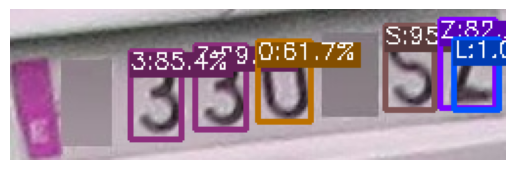

In [8]:
image_path = "/content/test_00038_1.jpg"
outputs, img_info = predictor.inference(image_path)
result_image = predictor.visual(outputs[0], img_info, predictor.confthre)

plt.figure()
plt.imshow(result_image[..., ::-1])
_ = plt.axis("off")